In [ ]:
!pip install googletrans
! pip install torch transformers
!pip install nltk
!pip install deep-translator

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 11.0 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15718 sha256=7e41af44f8b0c03aecf5f1aaa983b80812a63c72c8f098dddd38f1b3ee5a5621
  Stored in directory: /root/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling ch

In [ ]:
from googleapiclient.discovery import build
from textblob import TextBlob

from googletrans import Translator, LANGUAGES

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import pipeline

from matplotlib import pyplot as plt
import seaborn as sns

from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch

from transformers import BertForSequenceClassification, AdamW
from tqdm import tqdm
from sklearn.metrics import classification_report

import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from deep_translator import GoogleTranslator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
 # change the devloper key that corresponds to your google account please. I might get charged if no of comments passes a threshold. You will have to get an API from google developer console.
youtube = build('youtube', 'v3', developerKey='<your key')

def fetch_comments(video_id):
    comments = []
    response = youtube.commentThreads().list(part='snippet', videoId=video_id, textFormat='plainText').execute()

    while response:
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)

        # taking first 5000 comments
        if(len(comments) == 5000):
          break

        if 'nextPageToken' in response:
            response = youtube.commentThreads().list(part='snippet', videoId=video_id, textFormat='plainText', pageToken=response['nextPageToken']).execute()
        else:
            break

    return comments

def analyze_sentiment(comments):
    sentiments = {'positive': 0, 'neutral': 0, 'negative': 0}

    for comment in comments:
        analysis = TextBlob(comment)  -- see
        if analysis.sentiment.polarity > 0:
            sentiments['positive'] += 1
        elif analysis.sentiment.polarity == 0:
            sentiments['neutral'] += 1
        else:
            sentiments['negative'] += 1

    return sentiments

def translate_english(comments):
  translator = Translator()
  translated_comments = []

  for comment in tqdm(comments):
      if(len(comment)<=5000):
        translated_comment = GoogleTranslator(source='auto', target='en').translate(comment)
        translated_comments.append(translated_comment)

  return translated_comments

video_id = 'YQHsXMglC9A' # "Hello" by Adele Youtube video ID
comments = fetch_comments(video_id)

In [ ]:
comments = translate_english(comments)
# sentiments = analyze_sentiment(comments)
# print(sentiments)

100%|██████████| 5000/5000 [23:21<00:00,  3.57it/s]


In [ ]:
def clean_comment(comment):
    # Convert to lowercase
    comment = comment.lower()
    # Remove URLs
    comment = re.sub(r'https?://\S+|www\.\S+', '', comment)
    # Remove user mentions
    comment = re.sub(r'@\w+', '', comment)
    # Remove hashtags (only removing the hash # sign from the word)
    comment = re.sub(r'#', '', comment)
    # Remove HTML tags
    comment = re.sub(r'<.*?>', '', comment)
    # Remove punctuation and special chars
    comment = comment.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    comment = re.sub(r'\d+', '', comment)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(comment)
    filtered_words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    # Re-create the comment from words
    clean_comment = ' '.join(lemmatized_words)
    return clean_comment

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

result = []
scores = []
cleaned_comments = []
sentiment_pipeline = pipeline("sentiment-analysis")

comments = [x for x in comments if x!=None] # Remove any comments that we were unable to translate


for comment in tqdm(comments):
    comment = clean_comment(comment)
    tokens = tokenizer.tokenize(comment)
    if len(tokens) > 512:
        tokens = tokens[:500]
    truncated_comment = tokenizer.convert_tokens_to_string(tokens)
    bert_result = sentiment_pipeline(truncated_comment)
    cleaned_comments.append(truncated_comment)
    result.append(bert_result[0]['label'])
    scores.append(bert_result[0]['score'])

df_senti = pd.DataFrame({'comment':comments, 'cleaned_comment':cleaned_comments, 'sentiment':result, 'score':scores})
df_senti


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

100%|██████████| 4690/4690 [04:21<00:00, 17.94it/s]


,comment,cleaned_comment,sentiment,score
0,MARCH?!??,march,POSITIVE,0.997408
1,love this song,love song,POSITIVE,0.999822
2,"Love her , but it’s all about the money and I ...",love ’ money ’ scribe like video,POSITIVE,0.962878
3,I'm here ❤😂,im [UNK],NEGATIVE,0.552302
4,Cheap Thrills (feat. Sean Paul)\nSia,cheap thrill feat sean paul sia,NEGATIVE,0.983750
...,...,...,...,...
4685,2023 October 🔥🔥🔥,october [UNK],POSITIVE,0.858282
4686,If I could call my younger self right now I’d ...,could call younger self right ’ heartbeat [UNK...,NEGATIVE,0.969653
4687,In 2023🇲🇿🇲🇿😊,[UNK],NEGATIVE,0.697057
4688,2024??,,POSITIVE,0.748121


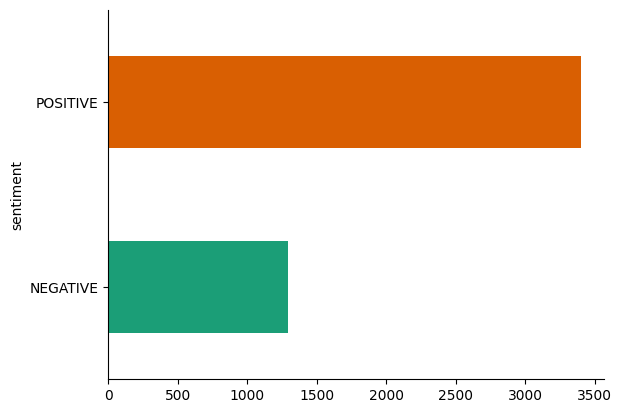

In [ ]:
df_senti.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

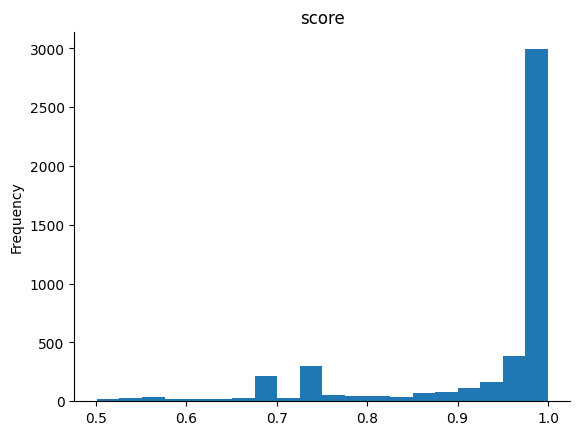

In [ ]:
df_senti['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-9-d40d3e133b2d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_senti, x='score', y='sentiment', inner='box', palette='Dark2')


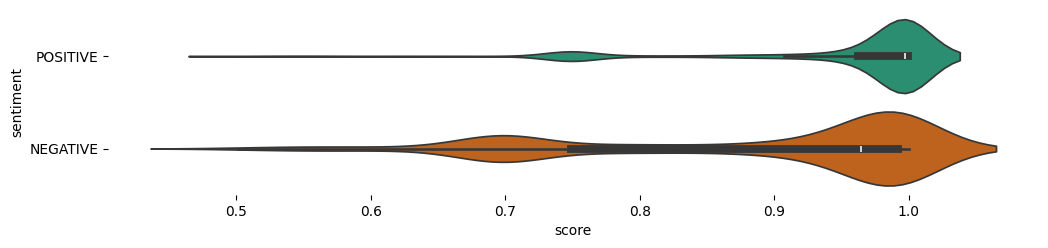

In [ ]:
figsize = (12, 1.2 * len(df_senti['sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_senti, x='score', y='sentiment', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
df = pd.read_csv("labeled_data.csv")
df['label'] = np.where(df['hate_speech'] > 0, 1, 0)
df = df[['tweet','label']]
train_df, val_df = train_test_split(df, test_size=0.1)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


MAX_LEN = 128
BATCH_SIZE = 16

train_dataset = HateSpeechDataset(
    texts=train_df.tweet.to_numpy(),
    labels=train_df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_dataset = HateSpeechDataset(
    texts=val_df.tweet.to_numpy(),
    labels=val_df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(3):
    model.train()
    for batch in tqdm(train_data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 1394/1394 [07:53<00:00,  2.94it/s]


In [ ]:
def evaluate_model(data_loader, model):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions.extend(torch.argmax(logits, dim=1).tolist())
            true_labels.extend(labels.tolist())

    print(classification_report(true_labels, predictions))

evaluate_model(val_data_loader, model)


              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1981
           1       0.56      0.47      0.51       498

    accuracy                           0.82      2479
   macro avg       0.72      0.69      0.70      2479
weighted avg       0.81      0.82      0.81      2479



In [ ]:
df_senti.loc[len(df_senti.index)] = ['die you deserve to die',"die","neg",0.99]

In [ ]:
class CommentDataset(Dataset):
    def __init__(self, comments, tokenizer, max_len):
        self.comments = comments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }


comment_dataset = CommentDataset(
    comments=df_senti['comment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

comment_data_loader = DataLoader(
    comment_dataset,
    batch_size=BATCH_SIZE
)

def get_predictions(model, data_loader):
    model = model.eval()

    comments_texts = []
    predictions = []
    prediction_probs = []

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds)
            prediction_probs.extend(outputs.logits)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    return predictions, prediction_probs

predictions, prediction_probs = get_predictions(model, comment_data_loader)

df_senti['predicted_label'] = predictions.numpy()


100%|██████████| 294/294 [00:35<00:00,  8.28it/s]


In [ ]:
df_senti[df_senti['predicted_label']==1]

,comment,cleaned_comment,sentiment,score,predicted_label
75,Who wath in this time,wath time,NEGATIVE,0.889797,1
101,Who's here in 2025?🫥,who,NEGATIVE,0.714945,1
122,Is this song about aborting their mixed race c...,song aborting mixed race child,POSITIVE,0.958219,1
181,THEY should remain with others at the camp or ...,remain others camp carry white sign good alive,POSITIVE,0.993015,1
232,Any Brazilians there?😅,brazilian [UNK],POSITIVE,0.927320,1
...,...,...,...,...,...
4497,This song reminds me with people living in pal...,song reminds people living palestine,POSITIVE,0.999263,1
4512,Is adele mixed race,adele mixed race,NEGATIVE,0.547064,1
4524,"Where are the inhabitants of your country, eve...",inhabitant country everywhere muslim draw conc...,POSITIVE,0.987260,1
4574,Where are the Arabs?\nFree palstine ❤🇵🇸,arab free palstine [UNK],NEGATIVE,0.910206,1


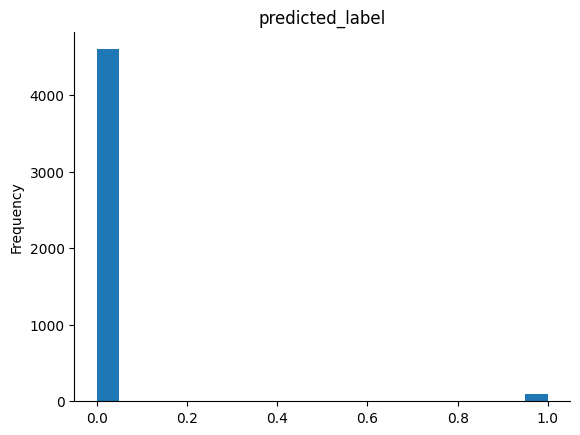

In [ ]:
df_senti['predicted_label'].plot(kind='hist', bins=20, title='predicted_label')
plt.gca().spines[['top', 'right',]].set_visible(False)

#**Trying this for clustering (Unsupervised)**

In [ ]:
comments = train_df['tweet'].astype(str).tolist()

# Parameters
max_features = 10000
maxlen = 100
embedding_dim = 32

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)

x_train = pad_sequences(sequences, maxlen=maxlen)

input_text = Input(shape=(maxlen,))
encoded = Dense(embedding_dim, activation='relu')(input_text)
decoded = Dense(maxlen, activation='sigmoid')(encoded)

autoencoder = Model(input_text, decoded)
encoder = Model(input_text, encoded)

autoencoder.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True)


Epoch 1/50
88/88 [==============================] - 2s 3ms/step - loss: -190165.6250
Epoch 2/50
88/88 [==============================] - 0s 3ms/step - loss: -1771839.3750
Epoch 3/50
88/88 [==============================] - 0s 3ms/step - loss: -6020745.5000
Epoch 4/50
88/88 [==============================] - 0s 3ms/step - loss: -12864299.0000
Epoch 5/50
88/88 [==============================] - 0s 3ms/step - loss: -22127502.0000
Epoch 6/50
88/88 [==============================] - 0s 3ms/step - loss: -33713296.0000
Epoch 7/50
88/88 [==============================] - 0s 4ms/step - loss: -47538724.0000
Epoch 8/50
88/88 [==============================] - 0s 4ms/step - loss: -63482948.0000
Epoch 9/50
88/88 [==============================] - 0s 4ms/step - loss: -81521504.0000
Epoch 10/50
88/88 [==============================] - 0s 4ms/step - loss: -101533928.0000
Epoch 11/50
88/88 [==============================] - 0s 5ms/step - loss: -123472760.0000
Epoch 12/50
88/88 [========================

In [ ]:
comments = df_senti['cleaned_comment'].astype(str).tolist()

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)

x_train = pad_sequences(sequences, maxlen=maxlen)
comment_embeddings = encoder.predict(x_train)

147/147 [==============================] - 0s 1ms/step


In [ ]:
# vectorizer = TfidfVectorizer(stop_words='english')
# X = vectorizer.fit_transform(df_senti['cleaned_comment'])

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(comment_embeddings)

df_senti['cluster'] = kmeans.labels_
df_senti

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,comment,cleaned_comment,sentiment,score,predicted_label,cluster
0,MARCH?!??,march,POSITIVE,0.997408,0,2
1,love this song,love song,POSITIVE,0.999822,0,2
2,"Love her , but it’s all about the money and I ...",love ’ money ’ scribe like video,POSITIVE,0.962878,0,2
3,I'm here ❤😂,im [UNK],NEGATIVE,0.552302,0,2
4,Cheap Thrills (feat. Sean Paul)\nSia,cheap thrill feat sean paul sia,NEGATIVE,0.983750,0,3
...,...,...,...,...,...,...
4686,If I could call my younger self right now I’d ...,could call younger self right ’ heartbeat [UNK...,NEGATIVE,0.969653,0,0
4687,In 2023🇲🇿🇲🇿😊,[UNK],NEGATIVE,0.697057,0,2
4688,2024??,,POSITIVE,0.748121,0,2
4689,+1,,POSITIVE,0.748121,0,2


<ipython-input-21-65b98de3e6eb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_senti, x='cluster', y='sentiment', inner='box', palette='Dark2')


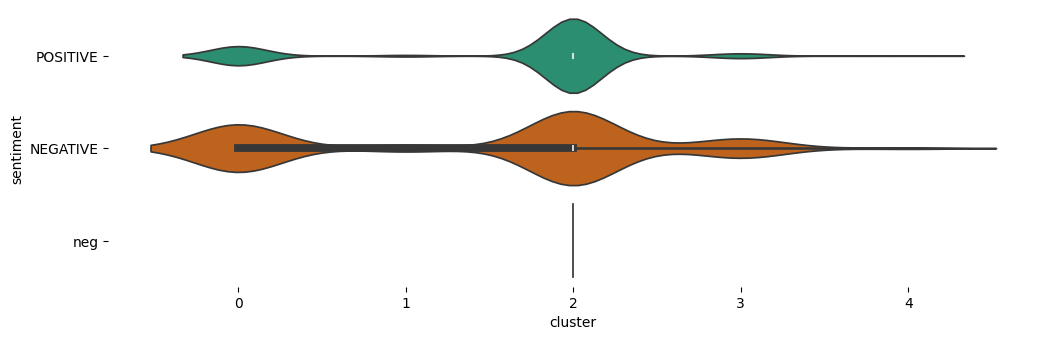

In [ ]:
figsize = (12, 1.2 * len(df_senti['sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_senti, x='cluster', y='sentiment', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, comment_embeddings)
representative_comments = df_senti['cleaned_comment'].iloc[closest]


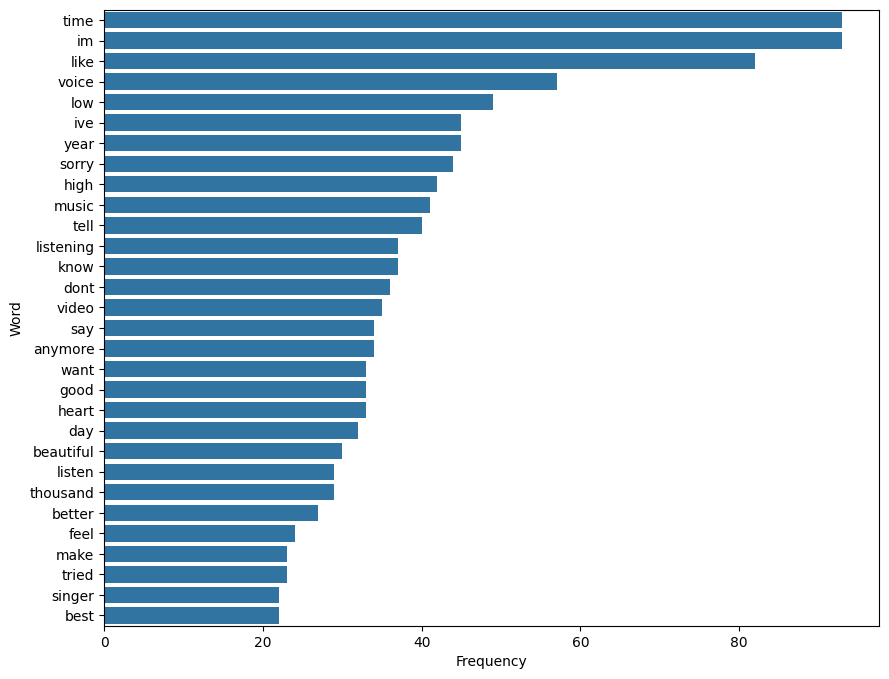

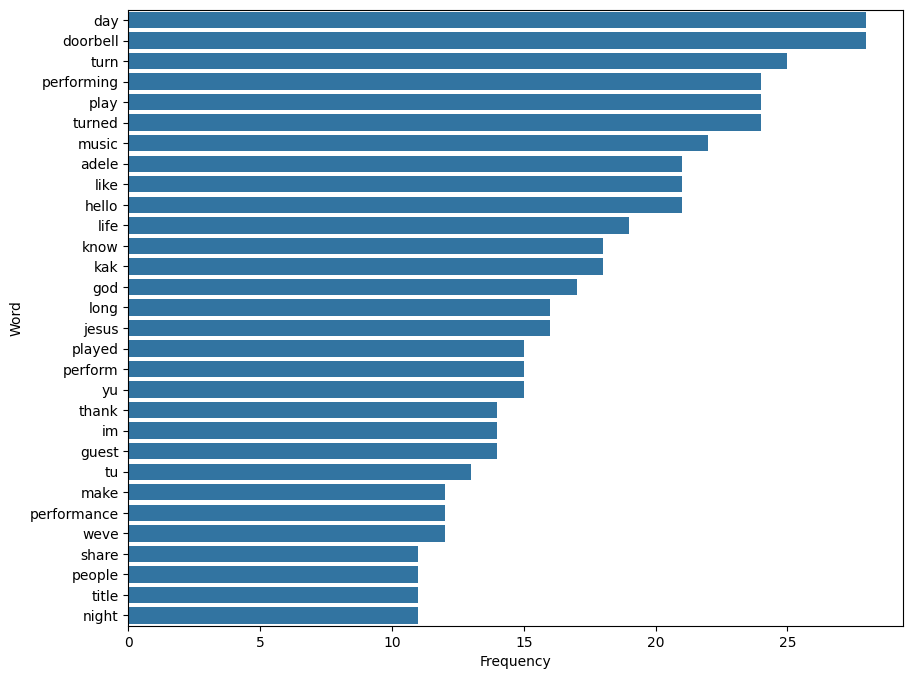

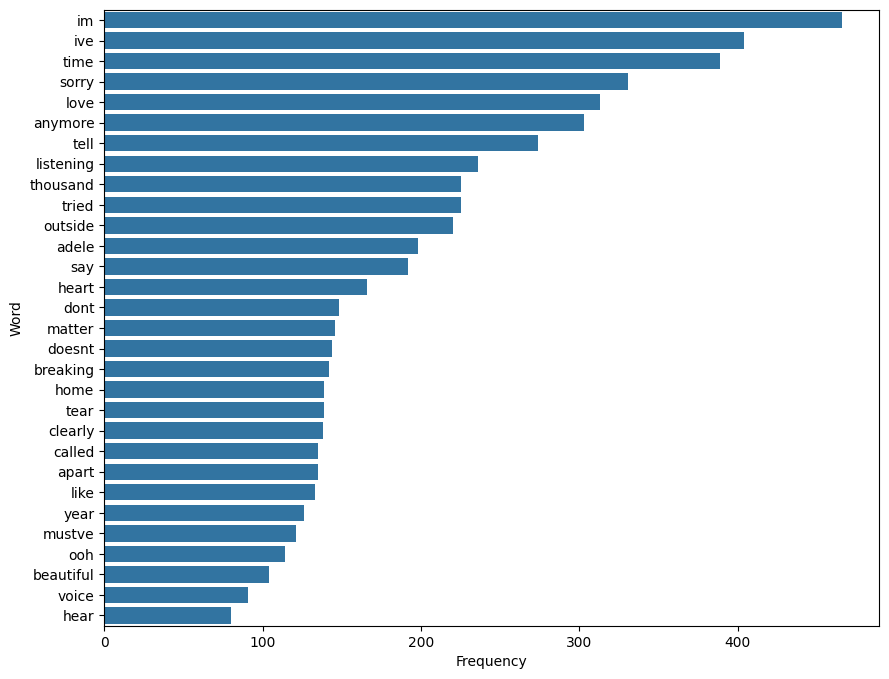

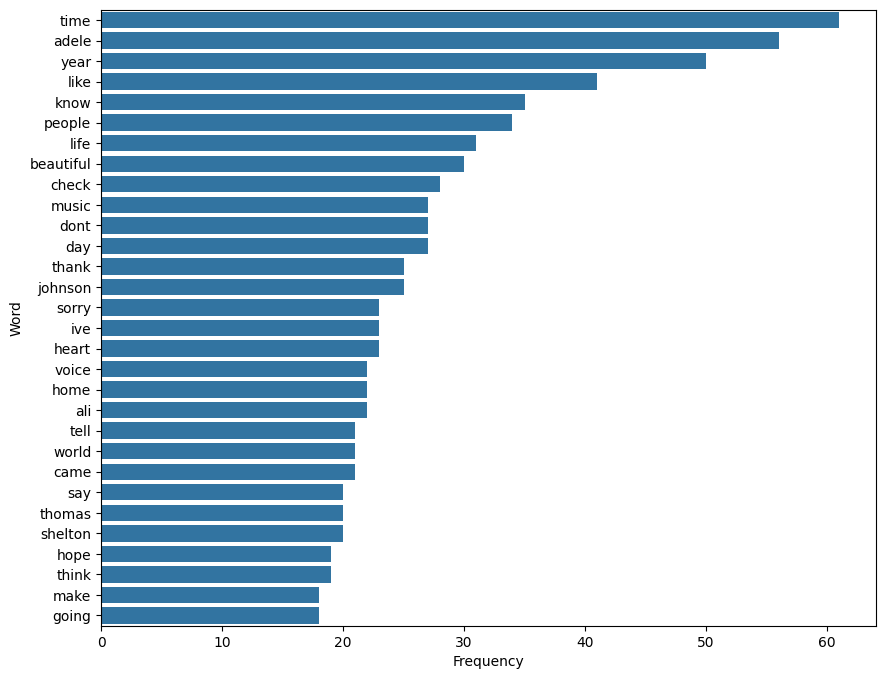

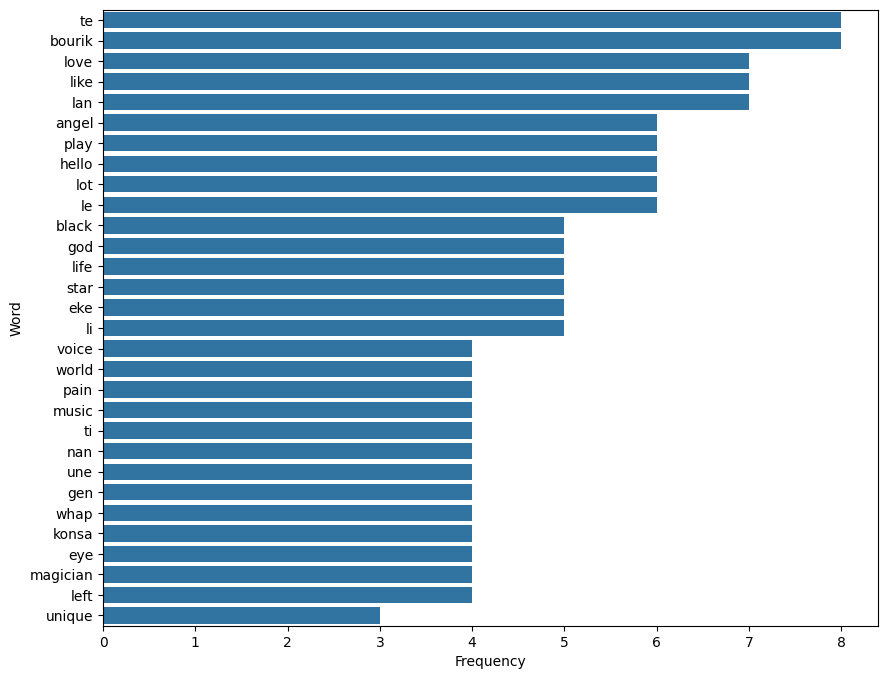

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
for i in range(num_clusters):
  all_words = vectorizer.fit_transform(df_senti[df_senti['cluster']==i]['cleaned_comment'])
  sum_words = all_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

  sorted_words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

  plt.figure(figsize=(10, 8))
  ax = sns.barplot(x=[w[1] for w in sorted_words_freq[5:35]], y=[w[0] for w in sorted_words_freq[5:35]])
  # plt.title('Top Words Across Cluster ',i)
  plt.xlabel('Frequency')
  plt.ylabel('Word')
  plt.show()


In [ ]:
# Apply LDA topic modeling to each cluster
n_topics = 1
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)

for i in range(kmeans.n_clusters):
    cluster_comments = df_senti[df_senti['cluster'] == i]['cleaned_comment']
    cluster_vectorized = vectorizer.transform(cluster_comments)
    lda.fit(cluster_vectorized)

    for idx, topic in enumerate(lda.components_):
        print(f"Cluster {i}, Topic {idx}")
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Cluster 0, Topic 0
['low', 'voice', 'like', 'im', 'time', 'hello', 'adele', 'love', 'song', 'unk']
Cluster 1, Topic 0
['play', 'turned', 'performing', 'turn', 'year', 'day', 'time', 'love', 'unk', 'song']
Cluster 2, Topic 0
['tell', 'love', 'time', 'ive', 'im', 'song', 'high', 'low', 'hello', 'unk']
Cluster 3, Topic 0
['know', 'like', 'year', 'adele', 'time', 'hello', 'im', 'love', 'song', 'unk']
Cluster 4, Topic 0
['lan', 'like', 'love', 'bourik', 'time', 'te', 'adele', 'song', 'im', 'unk']
